In [36]:
import os
import math
import numpy as np
import pandas as pd

# data normalization
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# model training
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU

# model prediction
from sklearn.metrics import mean_absolute_error

# for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.subplots as sp

In [5]:
%matplotlib inline

<h2>Table of Contents</h2>
<ul>
    <a href='#Load-in-data'>Load in data</a><br>
    <a href='#Data-splitting'>Data splitting</a><br>
    <a href='#Data-normalization'>Data normalization</a>
    <a href='#Model-training'>Model training</a><br>
    <a href='#Model-prediction'>Model prediction</a><br>
    <a href='#Summary'>Summary</a><br>
</ul>

In [6]:
# setting a seed
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

## Load in data

In [7]:
# ticker symbol for a company
ticker_symbol = 'TSLA'

In [14]:
# checking if file for it exists
path = f'processed_data/{ticker_symbol}'
if os.path.exists:
    path += f'/{os.listdir(path)[0]}'
    print(f'Most recent file will be used: {path}')
else:
    print('No folder found for ticker!')

Most recent file will be used: processed_data/TSLA/2023_08_30_19_58_32.csv


In [15]:
# read in file
df = pd.read_csv(path)

In [16]:
# setting date as the index
df['date'] = pd.to_datetime(df['date'])
df.set_index(pd.DatetimeIndex(df['date']), inplace=True)

In [17]:
df.head(3)

,date,volume,open,high,low,close,adjclose,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,RSI_14,ROC_14,DIFF_10
date,,,,,,,,,,,,,,,
2011-04-12,2011-04-12,1357400,25.080000,25.209999,24.299999,24.650000,24.650000,0.612515,0.084880,0.527635,23.9594,23.72635,49.263035,10.986045,0.730000
2011-04-13,2011-04-13,1211500,25.129999,25.690001,24.809999,24.930000,24.930000,0.528058,0.000338,0.527720,23.9798,23.73155,50.769381,11.643531,1.220001
2011-04-14,2011-04-14,983400,24.870001,25.280001,24.200001,25.139999,25.139999,0.472622,-0.044078,0.516700,24.0038,23.73810,51.922270,10.505492,-2.610001


In [18]:
df.columns

Index(['date', 'volume', 'open', 'high', 'low', 'close', 'adjclose',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_50', 'SMA_200',
       'RSI_14', 'ROC_14', 'DIFF_10'],
      dtype='object')

## Data splitting

In [26]:
train_prec = 0.8

# the columns that are used as training data (the predicted columns should be the last one) 
used_columns = [
    'volume', 'open', 'high', 'low', 'close',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 
    'SMA_50', 'SMA_200',
    'RSI_14', 
    'ROC_14', 
    'DIFF_10']
predicted_column = len(used_columns)-1
print(f'The predicted column: {used_columns[predicted_column]}')

prediction_range = used_columns[predicted_column].split('_').pop()
print(f'The prediction is {prediction_range} days into the future.')

The predicted column: DIFF_10
The prediction is 10 days into the future.


In [27]:
# getting the data that we are going to use
used_data = df[used_columns]

In [28]:
train_size = int(used_data.shape[0] * train_prec)

train_data = np.array(used_data[:train_size])
print(f'Train dataset size: {train_data.shape[0]}')
test_data = np.array(used_data[train_size:])
print(f'Test dataset size: {test_data.shape[0]}')

Train dataset size: 1857
Test dataset size: 465


## Data normalization

Normalizing stock prices is a tricky business. Different time periods can have drastically different price ranges, and if we normalize al these different periods together, then larger ranges will have a disproportionate effect on all data.

**Solution:**
We will separate our data into different periods, or windows, and normalize within them. 

Note: This will result in breaks between the periods, but if the window is big enough than this won't be a problem as there will only be a few of them.

In [40]:
# the number of periods, that our dataset will be broken into
normalization_windows = 5

In [41]:
scaler = StandardScaler()

In [42]:
# getting the size of one window
size_of_normalization_windows = math.ceil(used_data.shape[0] / normalization_windows)
print(f'This will result in {normalization_windows-1} breaks in the data.')
print(f'The window size will be {size_of_normalization_windows}.')

This will result in 4 breaks in the data.
The window size will be 465.


In [43]:
# normalizing training data
for i in range(0, train_data.shape[0], size_of_normalization_windows):
    window_end = i + size_of_normalization_windows
    train_data[i:window_end] = scaler.fit_transform(train_data[i:window_end])

In [44]:
# normalizing test data (without fitting the scaler to it!)
for i in range(0, test_data.shape[0], size_of_normalization_windows):
    window_end = i + size_of_normalization_windows
    test_data[i:window_end] = scaler.transform(test_data[i:window_end])

## Data sequences

In [50]:
# params
sequence_length = 30 # days
feature_num = len(used_columns) - 1

In [51]:
def create_data_sequence(data):
    '''
    Creates sequences that can be fed to LSTM like models.
    '''
    print(f'\tOriginal shape: {data.shape}')

    window_size = sequence_length
    print(f'\tSequence length: {window_size}')
    
    # removing last window's size
    data_size = data.shape[0] - window_size
    print(f'\tUsable data size: {data_size}')
    
    X = []
    y = []
    for i in range(0, data_size):
        # adding 'sequence lenght' amount of data points
        X.append(data[i:i+window_size, :predicted_column])
        
        # adding target value from last data point in the sequence
        y.append(data[i+window_size-1, predicted_column])  

    return np.array(X), np.array(y)

In [53]:
print('Creating training sequences')
X_train, y_train = create_data_sequence(train_data)
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')

print('\nCreating testing sequences')
X_test, y_test = create_data_sequence(test_data)
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Creating training sequences
Creating sequences...
	Original shape: (1857, 13)
	Sequence length: 30
	Usable data size: 1827
X_train: (1827, 30, 12)
y_train: (1827,)

Creating testing sequences
Creating sequences...
	Original shape: (465, 13)
	Sequence length: 30
	Usable data size: 435
X_test: (435, 30, 12)
y_test: (435,)


# Model training

In [54]:
# params for training
epochs = 15
batch_size = 128

optimizer = 'adam'
loss = 'mean_squared_error'

In [55]:
# creating model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, feature_num), seed=seed),
    #Dropout(0.2, seed=seed),
    #LSTM(20, activation='relu', seed=seed),
    # GRU layer
    Dense(1)
])

# compile model
model.compile(optimizer=optimizer, loss=loss)

# train model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/15
15/15 [==============================] - 1s 10ms/step - loss: 0.8323
Epoch 2/15
15/15 [==============================] - 0s 10ms/step - loss: 0.4587
Epoch 3/15
15/15 [==============================] - 0s 10ms/step - loss: 0.2705
Epoch 4/15
15/15 [==============================] - 0s 10ms/step - loss: 0.1814
Epoch 5/15
15/15 [==============================] - 0s 10ms/step - loss: 0.1545
Epoch 6/15
15/15 [==============================] - 0s 10ms/step - loss: 0.1386
Epoch 7/15
15/15 [==============================] - 0s 10ms/step - loss: 0.1306
Epoch 8/15
15/15 [==============================] - 0s 10ms/step - loss: 0.1255
Epoch 9/15
15/15 [==============================] - 0s 11ms/step - loss: 0.1178
Epoch 10/15
15/15 [==============================] - 0s 12ms/step - loss: 0.1071
Epoch 11/15
15/15 [==============================] - 0s 13ms/step - loss: 0.1021
Epoch 12/15
15/15 [==============================] - 0s 12ms/step - loss: 0.0981
Epoch 13/15
15/15 [==================

# Model prediction

In [56]:
# predict
y_pred = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


### Results

In [64]:
print(mean_absolute_error(y_test.reshape(-1,1), y_pred))

4.62190924919694


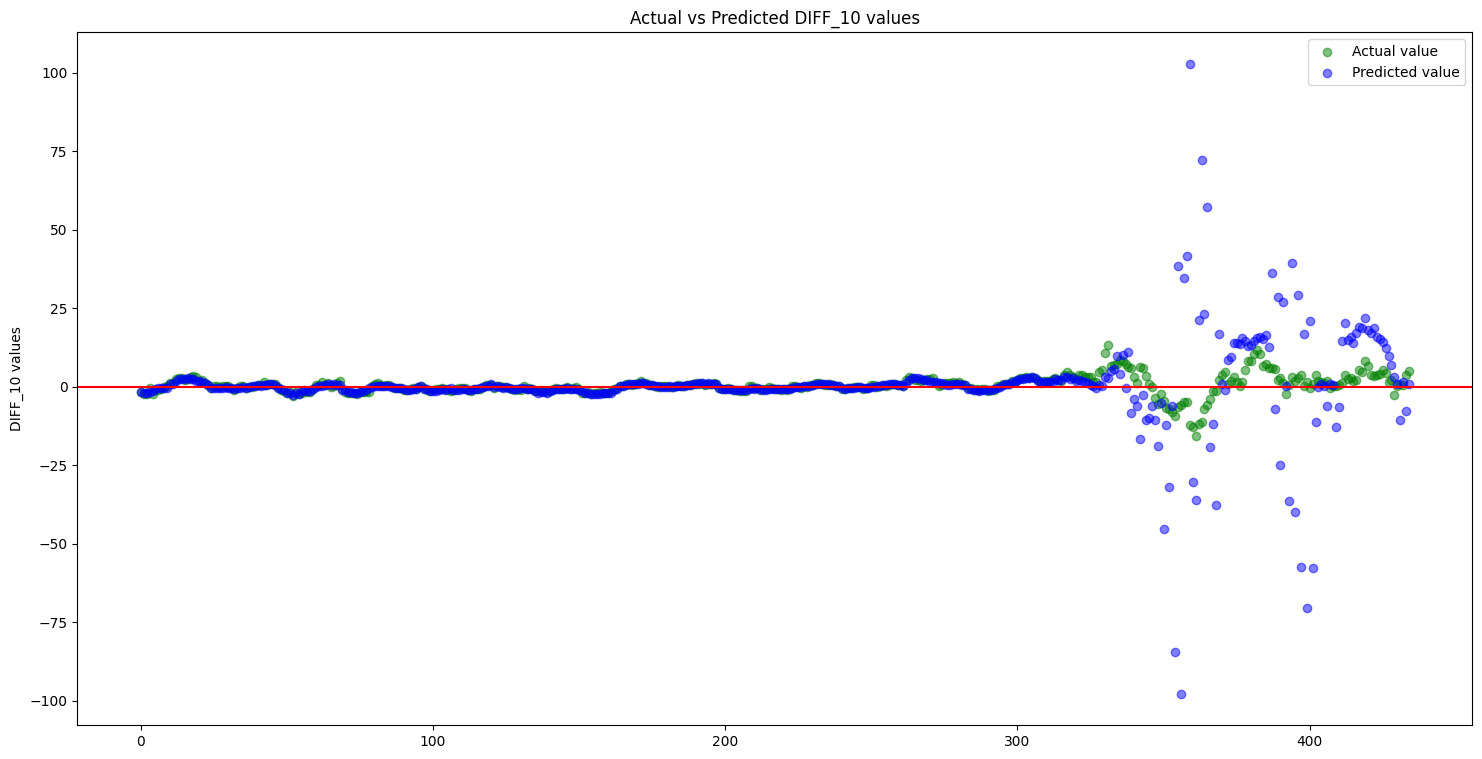

In [65]:
# check resulting score
plt.figure(figsize=(18,9))

# plot results vs actual
plt.scatter(range(y_test.shape[0]), y_test.reshape(-1,1), c='g', alpha=0.5, label='Actual value')
plt.scatter(range(y_pred.shape[0]), y_pred, c='b', alpha=0.5, label='Predicted value')

plt.axhline(y=0, c='r')
plt.legend()

plt.title(f'Actual vs Predicted {used_columns[-1]} values')
plt.ylabel(f'{used_columns[-1]} values')

plt.show()

### Results visualized

#### Creating dataframe with results

In [74]:
concat_pred = np.concatenate((test_data[:X_test.shape[0], :predicted_column], y_pred), axis=1)

In [75]:
result_df = pd.DataFrame(scaler.inverse_transform(concat_pred))
result_df.columns = used_columns
result_df.head(3)

,volume,open,high,low,close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,RSI_14,ROC_14,DIFF_10
0,7649100.0,318.410004,318.880005,311.190002,311.859985,-2.560148,-3.183611,0.623463,327.357601,318.615251,43.326793,-15.790898,-36.186102
1,7447400.0,310.269989,311.850006,303.690002,305.010010,-3.863209,-3.589338,-0.273871,326.406802,318.625351,40.742667,-13.460065,-42.660630
2,7216700.0,302.260010,304.600006,297.720001,303.149994,-4.988479,-3.771686,-1.216793,325.225402,318.564101,40.044258,-14.723339,-43.180792


In [78]:
# original just for comparison
test_range = (train_size, train_size+result_df.shape[0])
df.iloc[test_range[0]:test_range[1], :].head(3)

,date,volume,open,high,low,close,adjclose,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,RSI_14,ROC_14,DIFF_10
date,,,,,,,,,,,,,,,
2018-08-28,2018-08-28,7649100,318.410004,318.880005,311.190002,311.859985,311.859985,-2.560148,-3.183611,0.623463,327.357601,318.615251,43.326793,-15.790898,-35.780029
2018-08-29,2018-08-29,7447400,310.269989,311.850006,303.690002,305.010010,305.010010,-3.863209,-3.589338,-0.273871,326.406802,318.625351,40.742667,-13.460065,-33.679993
2018-08-30,2018-08-30,7216700,302.260010,304.600006,297.720001,303.149994,303.149994,-4.988479,-3.771686,-1.216793,325.225402,318.564101,40.044258,-14.723339,-32.300018


In [89]:
# adding back close price, if it wasn't used
if 'close' not in result_df.columns:
    result_df['close'] = df.iloc[test_range[0]:test_range[1]]['close'].reset_index(drop=True)
    
# adding back date
result_df['date'] = df.iloc[test_range[0]:test_range[1]]['date'].reset_index(drop=True)

result_df.head(3)

,volume,open,high,low,close,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_50,SMA_200,RSI_14,ROC_14,DIFF_10,date
0,7649100.0,318.410004,318.880005,311.190002,311.859985,-2.560148,-3.183611,0.623463,327.357601,318.615251,43.326793,-15.790898,-36.186102,2018-08-28
1,7447400.0,310.269989,311.850006,303.690002,305.010010,-3.863209,-3.589338,-0.273871,326.406802,318.625351,40.742667,-13.460065,-42.660630,2018-08-29
2,7216700.0,302.260010,304.600006,297.720001,303.149994,-4.988479,-3.771686,-1.216793,325.225402,318.564101,40.044258,-14.723339,-43.180792,2018-08-30


In [ ]:
plotted_data_size = X_test.shape[0] + sequence_length

# preparing data for plotting results
plotted_data = df[train_size:train_size+plotted_data_size]
plotted_data.reset_index(drop=True, inplace=True)

In [ ]:
# inverse transforming the predicted results
dummy_array = np.ones(shape=(y_pred.shape[0], feature_num))
inverse_y_pred = np.concatenate((dummy_array, y_pred), axis=1)

inverse_y_pred = scaler.inverse_transform(inverse_y_pred)[:, 1]

In [ ]:
def create_line_coords(data, shown_line_prec=0.1):
    shown_line_num = int(np.ceil(inverse_y_pred.shape[0] * shown_line_prec))
    offset = int(np.ceil(inverse_y_pred.shape[0] / shown_line_num))

    print(f'all lines: {inverse_y_pred.shape[0]}')
    print(f'shown lines: {shown_line_num}')
    print(f'gap between lines: {offset}')
    
    lines = pd.DataFrame()
    for i in range(0, shown_line_num):
        line_data_idx = sequence_length + i*offset
        if line_data_idx >= inverse_y_pred.shape[0]:
            break ## TODO - clean this up, make something better for this
            # Currently the problem is, that we are rounding the number up, so at the end the idx goes over the limit
            # even if round down, there will be problems in the visualization
        
        # the start of the line (the last price in the window)
        lines.loc[i, 'start_x'] = data.loc[line_data_idx, 'date']
        lines.loc[i, 'start_y'] = data.loc[line_data_idx, 'close']
        
        # the end of the line (10 day in the future)
        lines.loc[i, 'end_x'] = data.loc[line_data_idx, 'date'] + time_offset

    # adding the prediction
    lines['end_y'] = lines['start_y'] + data['difference']#pd.Series(inverse_y_pred)
    
    print(f'created {lines.shape[0]} lines')
    return lines

In [ ]:
# the difference's length
time_offset = pd.Timedelta(days=10)
shown_line_prec = 0.4

In [ ]:
lines = create_line_coords(results, shown_line_prec) # creating the start and the end of the lines

In [ ]:
mistake = results['orig_diff'] - results['difference']
mistake.describe()

In [ ]:
plt.figure(figsize=(18, 9))

plt.bar(x=range(mistake.shape[0]), height=mistake)

plt.show()

In [ ]:
fig = go.Figure()

# adding price
fig.add_trace(
    go.Scatter(
         x=results['date'], 
         y=results['close'],
         name='Closing price',
         line_color='blue',
    )
)
fig.update_yaxes(
    title_text='Close Price', 
    tickprefix='$'
)

# adding resulting momentum
for i in range(lines.shape[0]):
    fig.add_shape(
        type='line',
        x0=lines.loc[i, 'start_x'], x1=lines.loc[i, 'end_x'],
        y0=lines.loc[i, 'start_y'], y1=lines.loc[i, 'end_y'],
        line=dict(color='red', width=1)
    )

# general settings
#fig.update_yaxes(range=(150, 400))

fig.update_layout(
    title='Results',
    height=1200,
    title_x=0.5,
    xaxis_rangeslider_visible=True,
    xaxis_rangeslider_thickness=0.1
)

# showing a pretty plot
fig.show()

In [ ]:
X_test.reshape(-1,7)[:,0].shape

In [ ]:
used_columns

In [ ]:
test = X_test.reshape(-1,7)[:,0]

In [ ]:
fig = go.Figure()

# adding price
fig.add_trace(
    go.Scatter(
         x=np.arange(test.shape[0]), 
         y=np.arange(1),
         name='Closing price',
         line_color='blue',
    )
)
fig.update_yaxes(
    title_text='Close Price', 
    tickprefix='$'
)

# adding resulting momentum
for i in range(lines.shape[0]):
    break
    fig.add_shape(
        type='line',
        x0=lines.loc[i, 'start_x'], x1=lines.loc[i, 'end_x'],
        y0=lines.loc[i, 'start_y'], y1=lines.loc[i, 'end_y'],
        line=dict(color='red', width=1)
    )

# general settings
#fig.update_yaxes(range=(150, 400))

fig.update_layout(
    title='Results',
    height=1200,
    title_x=0.5,
    xaxis_rangeslider_visible=True,
    xaxis_rangeslider_thickness=0.1
)

# showing a pretty plot
fig.show()

# Summary

In [ ]:
# TODO
# save params and results for later comparison
# make comparison with earlier models
# look how much profit can be made by following the model (make some simple algo for trading)